## To do list

- Check that everything is working correctly with the newly processed data
   

## Import the necessary packages

In [1]:
%reset
import numpy as np
import pandas as pd
import scipy.stats as stat
import matplotlib as plt
import pickle

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(matplotlib.rcParams)
matplotlib.rcParams.update(inline_rc)

import seaborn as sns
#sns.set(style='ticks', palette='Set2')
sns.set(color_codes=True)

### Define the bayesian inference function

In [35]:
def norm_bayes(control,prior_data,sample_data,plot=True,n_params=1000):
    
    if control == 'pos':
        prior_data = np.log(prior_data)
        sample_data = np.log(sample_data)
        
    prior_stats = prior_data.describe()
    sample_stats = sample_data.describe()
    
    params = np.linspace(prior_stats[3],prior_stats[7],n_params) # Equally spaced values between min and max
    
    # Generate likelihood probability distribution
    # A.K.A. the probability distribution of all the actual data I'm working with
    
    likelihood = np.array(stat.norm.pdf(params,loc=sample_stats[1],scale=sample_stats[2]))
    likelihood = likelihood / np.sum(likelihood)

    # Generate a normal distribution of prior values
    # A.K.A. the expected distribution of what I'm working with
    # This is based on the known information of the entire sample
    # prior_sample = np.random.normal(loc=prior_stats[1],scale=prior_stats[2],size=int(prior_stats[0]))
    prior = np.array(stat.norm.pdf(params,loc=prior_stats[1],scale=prior_stats[2]))
    prior = prior / np.sum(prior)

    post = [prior[i] * likelihood[i] for i in range(n_params)]
    post = post / np.sum(post)
    
    if control == 'pos':
        bayesian_mean = np.exp(params[np.argmax(post)])
        prior_mean = np.exp(prior_stats[1])
        frequentist_mean = np.exp(sample_stats[1])
    else:
        bayesian_mean = params[np.argmax(post)]
        prior_mean = prior_stats[1]
        frequentist_mean = sample_stats[1]
        
    
    if plot:
        plt.figure(figsize=(12,8))
        plt.plot(params, likelihood,color='blue', label='Sample distribution mean: %.3f' %frequentist_mean,linewidth=2)
        plt.plot(params, prior,color='orange', label='Prior distribution mean: %.3f' %prior_mean,linewidth=2)
        plt.plot(params, post,color='red', label='Posterior distribution mean: %.3f' %bayesian_mean,linewidth=2)
        plt.axvline(x=params[np.argmax(post)], color='red', linestyle='--', alpha=0.5,linewidth=2)
        plt.axvline(x=sample_stats[1], color='blue', linestyle='--', alpha=0.5,linewidth=2)
        plt.axvline(x=prior_stats[1], color='orange', linestyle='--', alpha=0.5,linewidth=2)
        if well_type == 'pos':
            plt.xlabel('Log(ratio)')
        else:
            plt.xlabel('Ratio')
        plt.ylabel('Probability')
        plt.legend(loc='best')
        plt.show()
        
    
    return bayesian_mean, frequentist_mean

### Load the raw data

This data has not been processed in any way. There are no NPIs, bayesian means, outliers, etc.

In [36]:
with open('./data.pickle','rb') as f:
    data = pickle.load(f)

# Replace zero ratio values with the smallest non-zero values. This helps with the log transformation.
# Perhaps we'd rather replace this ad-hoc than permanently
data.loc[data.ratio<=0,'ratio'] = data.loc[data.ratio>0].ratio.min()

### Test data for normality: Q-Q plots

The negative control and experimental data is approximately normal. The positive control follows a log normal distribution, and as such any bayesian techniques must be applied to the log-transformed positive control data.

For more information, see [here](http://data.library.virginia.edu/understanding-q-q-plots/).

Quantiles are points in your data below which a certain proportion of your data fall, eg. the mean is the 0th quantile, below which 50% of the data falls (in a normal distribution).

Q-Q plots take your sample data, sort it in ascending order, and then plot them versus quantiles calculated from a theoretical distribution. The number of quantiles is selected to match the size of your sample data.

The positive control data fits a lognormal distribution, or rather the log transformed positive control data fits a normal distribution.

The negative control data fits a normal distribution provided the values are not too large. This suggests that very large ratio values are discordant with the general distribution, as indicated wherein deviance from the distribution in the Q-Q plot only occurs beyond the 2nd quantile (i.e. beyond a confidence value of 0.05).

The experimental data fits a right-skewed Gumbel distribution. The skew to the right is clearly visible in the histogram, and makes sense given that the experimental conditions are expected to reduce the ratio in the majority of cases due to the targeted nature of the screen.

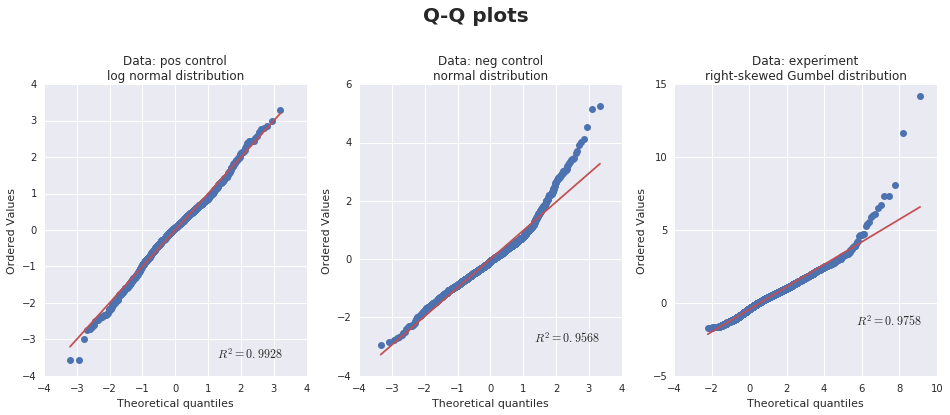

In [94]:
def qq(ax,well_type):
    
    sample = data.loc[(data.well_type==well_type)&(data.outlier==0)].dropna(subset=['ratio']).ratio.as_matrix()
    z = (sample-np.mean(sample))/np.std(sample)
        
    if well_type == 'pos':
        sample = np.log(sample)
        z = (sample-np.mean(sample))/np.std(sample)
        stat.probplot(z, dist=stat.norm, plot=ax,rvalue=True)
        ax.set_title('Data: %s control\nlog normal distribution' %well_type,size=12)
    
    
    if well_type == 'neg':
        stat.probplot(z, dist=stat.norm, plot=ax,rvalue=True)
        ax.set_title('Data: %s control\nnormal distribution' %well_type,size=12)
        
    if well_type=='experiment':
        stat.probplot(z, dist=stat.gumbel_r, plot=ax,rvalue=True)
        ax.set_title('Data: %s\nright-skewed Gumbel distribution' %well_type,size=12)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

fig, axes = plt.subplots(1,3,figsize=(16,6),sharex=False,sharey=False)
for ax,well_type in zip(axes,['pos','neg','experiment']):
    qq(ax,well_type)
plt.suptitle('Q-Q plots',size=20,fontweight='bold')
plt.subplots_adjust(top=0.80)
plt.show()

### Histogram and density plots of each well type

Here each control and the experimental data is plotted as a histogram with a density plot overlayed, and with the corresponding distribution plotted too. One expects the density plot and the distribution to align if the underlying data fits that distribution.

/home/nobody/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


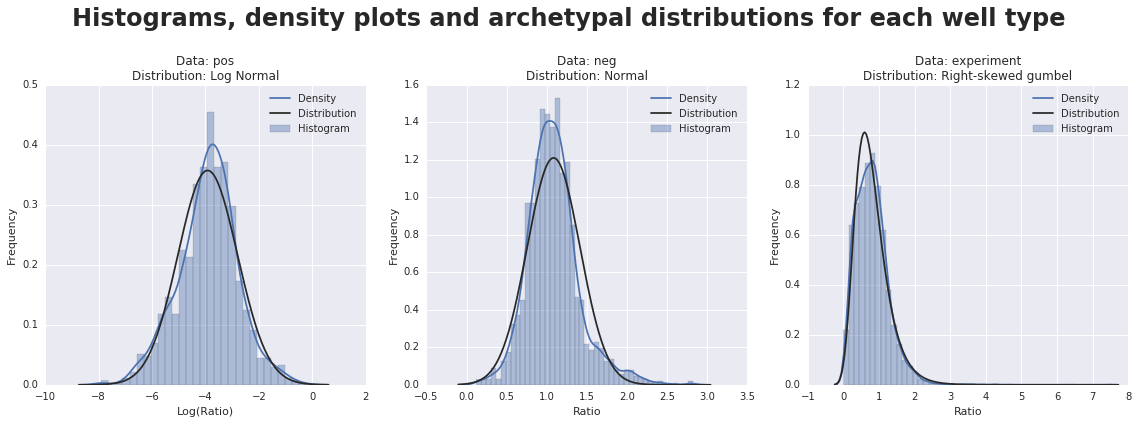

In [6]:
g, axes = plt.subplots(1, 3,figsize=(16,6))
dists = {'Normal':stat.norm,'Log Normal':stat.lognorm, 'Right-skewed gumbel':stat.gumbel_r}

for well_type,distribution,ax in zip(['pos','neg','experiment'],['Log Normal','Normal','Right-skewed gumbel'],axes):
    
    x = data.loc[data.well_type==well_type].dropna(subset=['ratio']).ratio
    
    if well_type == 'pos':
        x = np.log(x)
        ax.set_xlabel('log(Ratio)')
        
    sns.distplot(x, kde=True, fit=dists[distribution],ax=ax,kde_kws={"label": "Density"},hist_kws={"label": "Histogram"},fit_kws={"label": "Distribution"})
    
    if well_type == 'pos':
        ax.set_xlabel('Log(Ratio)')
    else:
        ax.set_xlabel('Ratio')
        
    ax.set_ylabel('Frequency')
    ax.set_title('Data: %s\nDistribution: %s' %(well_type,distribution))
    ax.legend()
    
plt.suptitle('Histograms, density plots and archetypal distributions for each well type',size=24,fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.8)

### Plot an example of bayesian inference of the mean

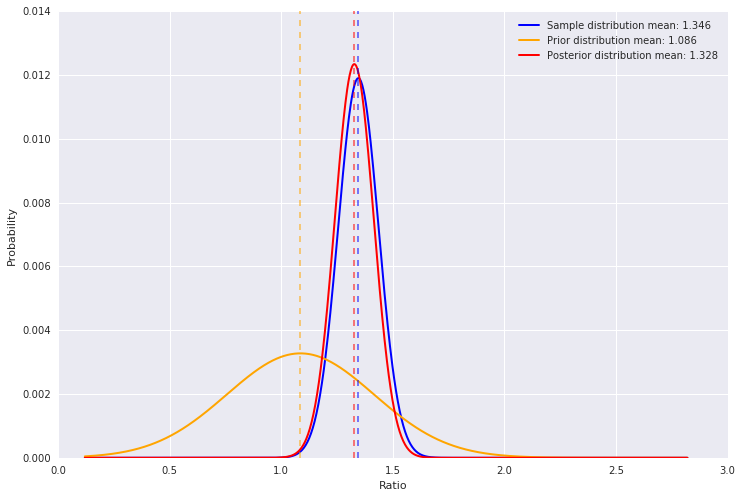

The frequentist mean is 1.346
The bayesian mean is 1.328
The global mean is 1.086


In [7]:
# Define the prior data
prior = data.groupby(['well_type']).get_group('neg')['ratio'].dropna()

# Define the sample data
sample = data.groupby(['well_type','plate_id']).get_group(('neg','A549-H3N2-39-3-2-1')).ratio.dropna()

# Save the bayesian and frequentist means, and plot the curves
bayes_mean, frequentist_mean = norm_bayes('neg',prior,sample,True)

print('The frequentist mean is %.3f\nThe bayesian mean is %.3f\nThe global mean is %.3f' 
      %(frequentist_mean, bayes_mean, prior.mean()))

### Calculate bayesian means for each plate

In [37]:
means = []

plt_grp = data.groupby(['plate_id','well_type','virus','date'])
for key in plt_grp.groups:
    
    if (key[1] != 'experiment') and (key[1] != 'other_control'):
        
        prior = data.groupby(['well_type']).get_group(key[1])['ratio'].dropna()
        sample = plt_grp.get_group(key)['ratio'].dropna()
        
        # Some plates have no controls due to error at time of plating
        # The if statements below account for these plates
        # In these cases. the bayesian mean is set to the median for all plates done on that day
        
        if sample.count() == 0:
            bayesian,frequentist = data.groupby(['well_type','date']).get_group((key[1],key[3]))['ratio'].median(), np.nan
            median = 1
        
        else:
            bayesian, frequentist = norm_bayes(key[1],prior,sample,plot=False,n_params=1000)
            median = 0
        
        means.append([key[2],key[3],key[0],key[1],frequentist,bayesian,abs(frequentist-bayesian),abs(data[data['well_type']==key[1]].ratio.mean()-frequentist),abs(data[data['well_type']==key[1]].ratio.mean()-bayesian),median])

means = pd.DataFrame(means,columns=['virus','date','plate_id','control','frequentist_mean','bayesian_mean','freq_bayes_diff','global_freq_diff','global_bayes_diff','bayes_is_median_not_inferred'])
means = means.sort_values(['control','freq_bayes_diff','plate_id'])
means.reset_index(inplace=True,drop=True)

# Export CSV
with open('./A549-outputs/A549-H1N1-H3N2-bayes-means.csv','w') as f:
    pd.DataFrame.to_csv(means,f)

# Pickle the data
with open('./A549-outputs/A549-H1N1-H3N2-bayes-means.pickle','wb') as f:
    pickle.dump(means, f, pickle.HIGHEST_PROTOCOL)  

### Calculate the NPI

This uses the corresponding bayesian mean for each plate in order to calculate the NPI for every row in the data set

In [38]:
# Calculate NPIs using bayesian means

def npi(row):
    NP = means.loc[(means.plate_id==row.plate_id) & (means.control=='pos')].bayesian_mean.values[0]
    DH2 = means.loc[(means.plate_id==row.plate_id) & (means.control=='neg')].bayesian_mean.values[0]
    return (NP - row.ratio)/(NP - DH2)

data['npi'] = data.apply(npi,axis=1)

In [39]:
# Pickle the data with NPI values

with open('./A549-outputs/A549_H1N1-H3N2-NPI.pickle','wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)    

### Using the bayesian mean to exclude outliers

For each control value (DH2 and NP), this function determines the likelihood of that recording occurring in the normal distribution based on the global mean and standard deviation for that control. If the probability of the recorded result is below 0.05, then the result is flagged as an outlier.

~1.2% of the control data is excluded using this approach.

In [58]:
# Outlier maker using ratios and normal distribution
# Final note: this seems to work the best

# Currently using a single threshold for all three well_types
ctrl_threshold = 0.05
exp_threshold = 0.01

def outlier(row):
    
    # Do not flag any other_control wells as outliers
    if row.well_type=='other_control':
        return 0
    
    elif row.well_type == 'experiment':
        mean = data.groupby(['well_type']).get_group((row.well_type)).ratio.mean()
        deviation = data.groupby(['well_type']).get_group((row.well_type)).ratio.std()
        if stat.gumbel_r.pdf(row.ratio,loc=mean,scale=deviation) < exp_threshold:
            return 1
        else:
            return 0
    
    # Log transform the positive control
    elif row.well_type == 'pos':
        mean = data.loc[data.well_type==row.well_type].ratio.apply(lambda x: np.log(x)).mean()
        deviation = data.loc[data.well_type==row.well_type].ratio.apply(lambda x: np.log(x)).std()
        if stat.norm.pdf(np.log(row.ratio),loc=mean,scale=deviation) < ctrl_threshold:
            return 1
        else:
            return 0
    
    # Use the negative control data as is
    elif row.well_type == 'neg':
        mean = data.loc[data.well_type==row.well_type].ratio.mean()
        deviation = data.loc[data.well_type==row.well_type].ratio.std()
        if stat.norm.pdf(row.ratio,loc=mean,scale=deviation) < ctrl_threshold:
            return 1
        else:
            return 0

data['outlier'] = data.apply(outlier,axis=1)

outlier_boundaries = pd.DataFrame({
    'pos':np.exp(stat.norm.interval(1-ctrl_threshold, loc=data.loc[data.well_type=='pos'].ratio.apply(lambda x: np.log(x)).mean(),scale=data.loc[data.well_type=='pos'].ratio.apply(lambda x: np.log(x)).std())),
    'neg':stat.norm.interval(1-ctrl_threshold, loc=data.loc[data.well_type=='neg'].ratio.mean(),scale=data.loc[data.well_type=='neg'].ratio.std()),
    'experiment':stat.gumbel_r.interval(1-exp_threshold, loc=data.loc[data.well_type=='experiment'].ratio.mean(),scale=data.loc[data.well_type=='experiment'].ratio.std())
},index=['lower','upper'])

print('%.3f%% of the positive control data is classified as an outlier.\nThe positive control interval is %s\n%.3f%% of the negative control data is classified as an outlier.\nThe negative control interval is %s\n%.3f%% of the experimental data is classified as an outlier.\nThe experiment interval is %s'
      %(
        data.loc[(data.well_type=='pos')].outlier.mean()*100,
        outlier_boundaries.loc[:,'pos'].values,
        data.loc[(data.well_type=='neg')].outlier.mean()*100,
        outlier_boundaries.loc[:,'neg'].values,
        data.loc[(data.well_type=='experiment')].outlier.mean()*100,
        outlier_boundaries.loc[:,'experiment'].values
    )
     )

5.437% of the positive control data is classified as an outlier.
The positive control interval is [ 0.00225066  0.17995649]
2.710% of the negative control data is classified as an outlier.
The negative control interval is (0.44006990643684585, 1.732339341004455)
0.187% of the experimental data is classified as an outlier.
The experiment interval is (0.018366380943580007, 3.2931040341189259)


In [73]:
outlier_boundaries

,experiment,neg,pos
lower,0.018366,0.23704,0.002251
upper,3.293104,1.93537,0.179956


### Box plots

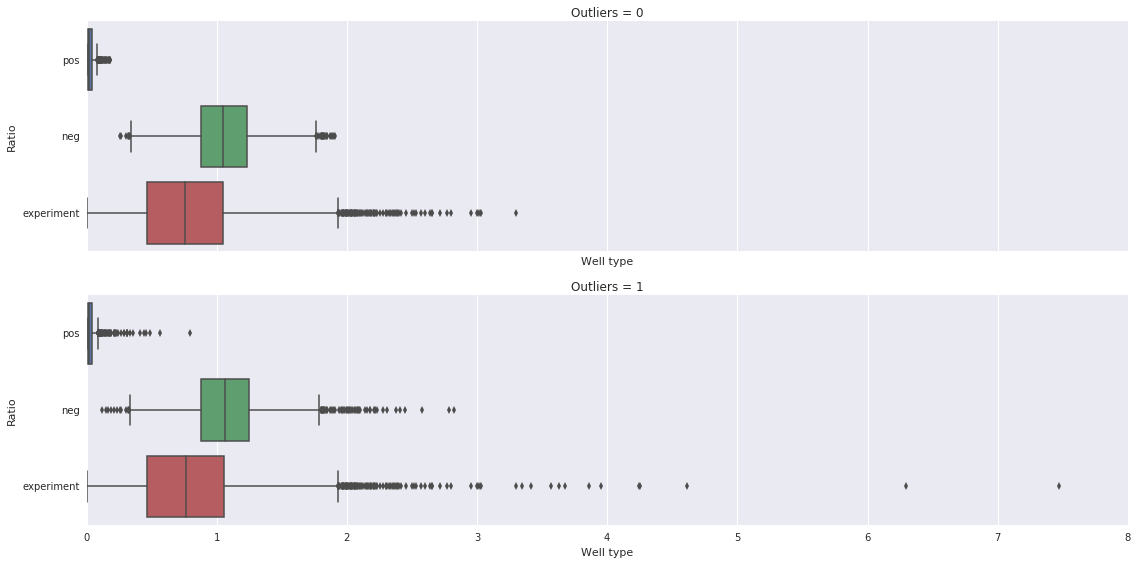

In [59]:
fig,axes = plt.subplots(2,1,sharex=True,figsize=(16,8))
for ax,outlier in zip(axes,[0,1]):
    sns.boxplot(data=data.loc[(data.well_type!='other_control')&(data.outlier<=outlier)],
            y='well_type',x='ratio',linewidth=1.5,order=['pos','neg','experiment'],ax=ax)
    ax.set_xlabel('Well type')
    ax.set_ylabel('Ratio')
    ax.set_title('Outliers = %.0f' %outlier)
plt.tight_layout()
plt.show()
#fig.title("Box plots showing the distribution of \npositive, negative and experimental ratio values",size=16)

In [60]:
# Pickle the data with NPI values and outliers

with open('./A549-outputs/A549-H1N1-H3N2-NPI-outliers.pickle','wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)    

### Calculate the per-plate SSMD

For each plate, the bayesian mean is collected from the means variable and the std deviation of the plate is calculated, for both controls. Outliers are excluded using the flag set above. The SSMD is calculated and the final result is stored in a dataframe, exported to CSV and pickled.

In [61]:
plate_ssmd = []

grouped = data.groupby(['plate_id'])

for key in grouped.groups:
    current_data = grouped.get_group(key)
    
    # Get bayesian means
    DH2_mean = means.loc[(means.plate_id == key) & (means.control == 'neg')].bayesian_mean.values[0]
    NP_mean = means.loc[(means.plate_id == key) & (means.control == 'pos')].bayesian_mean.values[0]
    
    # Calculate the std deviation, excluding outliers
    DH2_std = current_data.loc[(current_data.well_type == 'neg') & (current_data.outlier == 0)].ratio.std()
    NP_std = current_data.loc[(current_data.well_type == 'pos') & (current_data.outlier == 0)].ratio.std()
    
    # Calculate the SSMD and append it to the list
    ssmd_value = (DH2_mean-NP_mean)/(DH2_std**2+NP_std**2)**0.5
    plate_ssmd.append([key,ssmd_value])

plate_ssmd = pd.DataFrame(plate_ssmd,columns=['plate_id','ssmd'])

with open('./A549-outputs/A549-H1N1-H3N2-plate-ssmd.pickle','wb') as f:
    pickle.dump(plate_ssmd, f, pickle.HIGHEST_PROTOCOL) 
    
with open('./A549-outputs/A549-H1N1-H3N2-plate-ssmd.csv','w') as f:
    pd.DataFrame.to_csv(plate_ssmd,f)

In [82]:
# List the plates that do not meet the threshold of 3
plate_ssmd.loc[plate_ssmd.ssmd<3].sort_values(['plate_id'])

,plate_id,ssmd
27,A549-H1N1-39_Q-2-4-3,2.960979
59,A549-H1N1-pilot-3-3,2.892227
9,A549-H3N2-39-3-5-1,2.706832
119,A549-H3N2-39-3-6-3,2.082306


In [63]:
# Calculate the global SSMD
global_ssmd = (data.loc[(data.well_type=='neg')&(data.outlier!=1)].ratio.mean()-data.loc[(data.well_type=='pos')&(data.outlier!=1)].ratio.mean())/(data.loc[(data.well_type=='neg')&(data.outlier!=1)].ratio.std()**2+data.loc[(data.well_type=='pos')&(data.outlier!=1)].ratio.std()**2)**0.5
print('The global SSMD is %.4f' %global_ssmd)

The global SSMD is 3.6642


### Find the number of repeats done per siRNA

In [88]:
# The mask filters out the plate_id's which do not meet the SSMD > 3 threshold
mask = data.plate_id.isin(plate_ssmd.loc[plate_ssmd.ssmd<3].plate_id)

number_of_repeats = pd.DataFrame(data[~mask].groupby(['virus','gene_symbol','sirna']).ratio.count()/3)

#number_of_repeats
with open('./A549-outputs/A549-H1N1-H3N2-number_of_repeats_per_siRNA.csv','w') as f:
    pd.DataFrame.to_csv(number_of_repeats,f)

### Average the NPI value per siRNA

Calculate the average NPI for each siRNA for each gene

In [89]:
average_npi = []

grouped = data[~mask].dropna(subset=['gene_symbol']).groupby(['virus','gene_symbol','sirna','well_type'])

for key in grouped.groups:
    if key[3] == 'experiment':
        count,mean,std,minimum,maximum,median = grouped.get_group(key).npi.describe()[[0,1,2,3,7,5]]
        average_npi.append([key[0],key[1],key[2],count,mean,std,minimum,maximum,median])
        
average_npi = pd.DataFrame(average_npi,columns=['virus','gene_symbol','sirna','count','mean','std','minimum','maximum','median'])
average_npi = average_npi.sort_values(['virus','gene_symbol','sirna'])
average_npi.reset_index(inplace=True,drop=True)

with open('./A549-outputs/A549-H1N1-H3N2-average_npi_per_siRNA.pickle','wb') as f:
    pickle.dump(average_npi, f, pickle.HIGHEST_PROTOCOL) 
    
with open('./A549-outputs/A549-H1N1-H3N2-average_npi_per_siRNA.csv','w') as f:
    pd.DataFrame.to_csv(average_npi,f)

In [93]:
average_npi.head()

,virus,gene_symbol,sirna,count,mean,std,minimum,maximum,median
631,H3N2,c14orf166,D2,8.0,0.819215,0.173511,0.501917,1.073365,0.821569
632,H3N2,c14orf166,D3,8.0,0.466766,0.255736,0.180181,0.934050,0.416764
633,H3N2,c14orf166,Q1,8.0,0.441062,0.109345,0.249082,0.561798,0.483689
634,H3N2,c14orf166,Q2,8.0,0.373184,0.136931,0.140350,0.547696,0.414645
635,H3N2,c14orf166,Q3,8.0,0.861800,0.209631,0.552622,1.300384,0.836206


### Tally the number of siRNA hits per gene

Here we count the number of hits that are below the threshold of `0.6` for each gene, across both virus subtypes.

In [91]:
number_hits = {}

grouped = average_npi.groupby('gene_symbol')
for gene in grouped.groups:
    number_hits[gene] = {}
    gene_data = grouped.get_group(gene).groupby('virus')
    for virus in gene_data.groups:
        virus_data = gene_data.get_group(virus)
        count = virus_data.loc[virus_data['mean'] < 0.6].shape[0]
        number_hits[gene][virus] = count
        
number_hits = pd.DataFrame(number_hits).transpose()
number_hits.index.rename('gene_symbol',inplace=True)
number_hits.reset_index(inplace=True)

with open('./A549-outputs/A549-H1N1-H3N2-number_hits_per_gene.pickle','wb') as f:
    pickle.dump(number_hits, f, pickle.HIGHEST_PROTOCOL) 
    
with open('./A549-outputs/A549-H1N1-H3N2-number_hits_per_gene.csv','w') as f:
    pd.DataFrame.to_csv(number_hits,f)

## Plotting

No real work has been done here. See above.

### Old outlier detection methods

These are deprecated but stored here for reference.

In [376]:
# Outlier maker using NPIs
data.drop('outlier')
def outlier(row):
    
    if row.well_type == 'experiment':
        return 0
    else:
        # Mean of the NPI for the plate
        mean = data.groupby(['plate_id','well_type']).get_group((row.plate_id,row.well_type)).npi.mean()
        # SD of the NPI for the plate
        deviation = data.groupby(['well_type']).get_group((row.plate_id,row.well_type)).npi.std()
        sensitivity = 2
        boundary = (mean-sensitivity*deviation,mean+sensitivity*deviation)
        if (row.ratio < boundary[0]) or (row.ratio > boundary[1]):
            return 1
        else:
            return 0

data['outlier'] = data.apply(outlier,axis=1)
print('%f%% of the data is classified as an outlier.' %(data.outlier.mean()*100))

9.492754% of the data is classified as an outlier.


In [398]:
# Outlier maker using mean / std of ratio value
data.drop('outlier')
def outlier(row):
    
    if row.well_type == 'experiment':
        return 0
    else:
        # Bayesian mean
        mean = means.loc[(means.plate_id == row.plate_id) & (means.control == row.well_type)].bayesian_mean.values[0]
        deviation = data.loc[data.well_type==row.well_type].ratio.std()
        sensitivity = 2
        boundary = (mean-sensitivity*deviation,mean+sensitivity*deviation)
        if (row.ratio < boundary[0]) or (row.ratio > boundary[1]):
            return 1
        else:
            return 0

data['outlier'] = data.apply(outlier,axis=1)
print('%f%% of the data is classified as an outlier.' %(data.outlier.mean()*100))

0.693582% of the data is classified as an outlier.
